c:\Users\fiyin\anaconda3\envs\qiskit_env\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:270: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\fiyin\anaconda3\envs\qiskit_env\lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


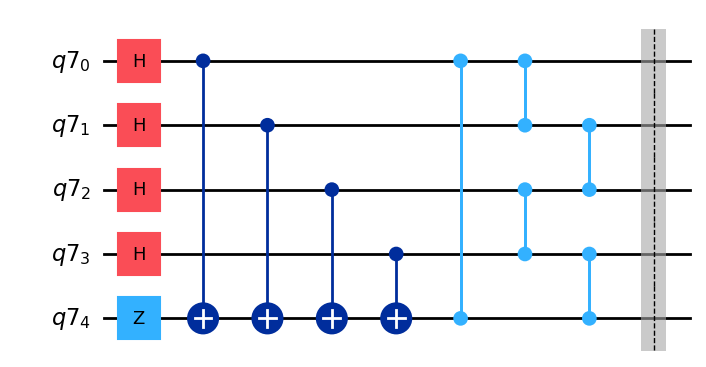

In [13]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import matplotlib as _  # ensure matplotlib inline

def encoding_circuit(circuit):
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    circuit.z(4)

    circuit.cx(0, 4)
    circuit.cx(1, 4)
    circuit.cx(2, 4)
    circuit.cx(3, 4)
    circuit.cz(0, 4)
    circuit.cz(0, 1)
    circuit.cz(2, 3)
    circuit.cz(1, 2)
    circuit.cz(3, 4)
    circuit.barrier()

# Create quantum circuit with 5 qubits
qreg = QuantumRegister(5)
circuit = QuantumCircuit(qreg)

# Apply encoding
encoding_circuit(circuit)

# Draw circuit using matplotlib
circuit.draw('mpl', style='iqx')

In [14]:
from qiskit.quantum_info import Statevector

# Returns the output statevector of the given circuit
statevec = Statevector.from_instruction(circuit.reverse_bits())
statevec.draw(output = 'latex')

<IPython.core.display.Latex object>